# Dataset generation: ProGraML x POJ104 <a class='tocSkip'>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Configs" data-toc-modified-id="Configs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Configs</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Graph-Tuple-Legend" data-toc-modified-id="Graph-Tuple-Legend-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Graph Tuple Legend</a></span><ul class="toc-item"><li><span><a href="#adjacencies:-np.array" data-toc-modified-id="adjacencies:-np.array-1.0.1.1"><span class="toc-item-num">1.0.1.1&nbsp;&nbsp;</span><code>adjacencies: np.array</code></a></span></li><li><span><a href="#edge_positions:-np.array" data-toc-modified-id="edge_positions:-np.array-1.0.1.2"><span class="toc-item-num">1.0.1.2&nbsp;&nbsp;</span><code>edge_positions: np.array</code></a></span></li><li><span><a href="#node_x:-np.array" data-toc-modified-id="node_x:-np.array-1.0.1.3"><span class="toc-item-num">1.0.1.3&nbsp;&nbsp;</span><code>node_x: np.array</code></a></span></li><li><span><a href="#node_y:-Optional[np.array]-=-None" data-toc-modified-id="node_y:-Optional[np.array]-=-None-1.0.1.4"><span class="toc-item-num">1.0.1.4&nbsp;&nbsp;</span><code>node_y: Optional[np.array] = None</code></a></span></li><li><span><a href="#graph_x:-Optional[np.array]-=-None" data-toc-modified-id="graph_x:-Optional[np.array]-=-None-1.0.1.5"><span class="toc-item-num">1.0.1.5&nbsp;&nbsp;</span><code>graph_x: Optional[np.array] = None</code></a></span></li><li><span><a href="#graph_y:-Optional[np.array]-=-None" data-toc-modified-id="graph_y:-Optional[np.array]-=-None-1.0.1.6"><span class="toc-item-num">1.0.1.6&nbsp;&nbsp;</span><code>graph_y: Optional[np.array] = None</code></a></span></li></ul></li><li><span><a href="#Disjoint-graph-properties" data-toc-modified-id="Disjoint-graph-properties-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Disjoint graph properties</a></span><ul class="toc-item"><li><span><a href="#disjoint_graph_count:-int-=-1" data-toc-modified-id="disjoint_graph_count:-int-=-1-1.0.2.1"><span class="toc-item-num">1.0.2.1&nbsp;&nbsp;</span><code>disjoint_graph_count: int = 1</code></a></span></li><li><span><a href="#disjoint_nodes_list:-np.array-=-None" data-toc-modified-id="disjoint_nodes_list:-np.array-=-None-1.0.2.2"><span class="toc-item-num">1.0.2.2&nbsp;&nbsp;</span><code>disjoint_nodes_list: np.array = None</code></a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Example-Data-Samples" data-toc-modified-id="Example-Data-Samples-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Example Data Samples</a></span><ul class="toc-item"><li><span><a href="#Proto-Example:-(NB:-this-uses-a-proto-with-broken-tokenization)" data-toc-modified-id="Proto-Example:-(NB:-this-uses-a-proto-with-broken-tokenization)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Proto Example: (NB: this uses a proto with broken tokenization)</a></span><ul class="toc-item"><li><span><a href="#Inspect-common-node-IDs:" data-toc-modified-id="Inspect-common-node-IDs:-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Inspect common node IDs:</a></span></li></ul></li><li><span><a href="#Draw-a-sample-graph" data-toc-modified-id="Draw-a-sample-graph-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Draw a sample graph</a></span><ul class="toc-item"><li><span><a href="#from-.ll-example" data-toc-modified-id="from-.ll-example-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>from .ll example</a></span></li><li><span><a href="#GraphTuple-example" data-toc-modified-id="GraphTuple-example-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>GraphTuple example</a></span></li><li><span><a href="#Collect-Token-distribution-stats-on-the-example" data-toc-modified-id="Collect-Token-distribution-stats-on-the-example-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Collect Token distribution stats on the example</a></span></li></ul></li></ul></li><li><span><a href="#Main:-Preprocess-Datasets" data-toc-modified-id="Main:-Preprocess-Datasets-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Main: Preprocess Datasets</a></span><ul class="toc-item"><li><span><a href="#Dev:-tuple2data---GraphTuple-->-Pyg-data.Data" data-toc-modified-id="Dev:-tuple2data---GraphTuple-->-Pyg-data.Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Dev: tuple2data - GraphTuple -&gt; Pyg data.Data</a></span></li><li><span><a href="#Dev:-nx2data-(more-flexible!)" data-toc-modified-id="Dev:-nx2data-(more-flexible!)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Dev: nx2data (more flexible!)</a></span><ul class="toc-item"><li><span><a href="#By-Example" data-toc-modified-id="By-Example-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>By Example</a></span></li><li><span><a href="#unit-test-on-this-example" data-toc-modified-id="unit-test-on-this-example-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>unit test on this example</a></span></li><li><span><a href="#coalesce-into-nx2data-function" data-toc-modified-id="coalesce-into-nx2data-function-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>coalesce into nx2data function</a></span></li></ul></li><li><span><a href="#needs-action:" data-toc-modified-id="needs-action:-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span><em>needs action:</em></a></span><ul class="toc-item"><li><span><a href="#Process-validation-set" data-toc-modified-id="Process-validation-set-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Process validation set</a></span></li><li><span><a href="#Process-test-set" data-toc-modified-id="Process-test-set-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Process test set</a></span></li><li><span><a href="#Process-train-set" data-toc-modified-id="Process-train-set-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Process train set</a></span></li></ul></li></ul></li><li><span><a href="#Development-of-Pytorch-Geometric-Dataset" data-toc-modified-id="Development-of-Pytorch-Geometric-Dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Development of Pytorch-Geometric Dataset</a></span></li><li><span><a href="#Finished-Dataset" data-toc-modified-id="Finished-Dataset-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Finished Dataset</a></span></li><li><span><a href="#TBD:-upcoming-work-section" data-toc-modified-id="TBD:-upcoming-work-section-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>TBD: upcoming work section</a></span></li></ul></div>

# Configs

In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
# get root repository path
a = !pwd
repo_root = a[0].rsplit('ProGraML', maxsplit=1,)[0] + 'ProGraML'
print(repo_root)
#insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, repo_root)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/zacharias/ProGraML


In [16]:
from pathlib import Path
import pickle


import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import tqdm
import torch
from torch_geometric.data import Data, DataLoader, InMemoryDataset
import torch_geometric

In [17]:
from google.protobuf import text_format
from deeplearning.ml4pl.graphs import programl
from deeplearning.ml4pl.graphs.labelled import graph_tuple
from labm8.py import app

In [18]:
from deeplearning.ml4pl.graphs.unlabelled.llvm2graph import graph_builder

builder = graph_builder.ProGraMLGraphBuilder()

### Graph Tuple Legend


#### ```adjacencies: np.array```

A list of adjacency lists, one for each flow type, where an entry in an
adjacency list is a <src,dst> tuple of node indices.

`Shape (edge_flow_count, edge_count, 2), dtype int32`


#### ```edge_positions: np.array```

A list of edge positions, one for each edge type. An edge position is an
integer in the range 0 <= x < edge_position_max.

`Shape (edge_flow_count, edge_count), dtype int32`



#### ```node_x: np.array```

A list of node feature arrays. Each row is a node, and each column is an
feature for that node.

`Shape (node_count, node_x_dimensionality), dtype int32`


#### ```node_y: Optional[np.array] = None```

(optional) A list of node labels arrays.

`Shape (node_count, node_y_dimensionality), dtype float32`


#### ```graph_x: Optional[np.array] = None```

(optional) A list of graph features arrays.

`Shape (graph_x_dimensionality) OR (graph_count, graph_x_dimensionality) if
graph_count > 1, dtype int32`



#### ```graph_y: Optional[np.array] = None```

(optional) A vector of graph labels arrays.

`Shape (graph_y_dimensionality) OR (graph_count, graph_y_dimensionality) if
graph_count > 1, dtype float32`


### Disjoint graph properties

#### ```disjoint_graph_count: int = 1```

The number of disconnected graphs in the tuple.


#### ```disjoint_nodes_list: np.array = None```

A list of integers which segment the nodes by graph. E.g. with a GraphTuple
of two distinct graphs, both with three nodes, nodes_list will be
[0, 0, 0, 1, 1, 1].
`Shape (node_count), dtype int32:`


# Example Data Samples

## Proto Example: (NB: this uses a proto with broken tokenization)

In [19]:
# proto example
from google.protobuf import text_format
from deeplearning.ml4pl.graphs import programl_pb2 as proto

program_graph = proto.ProgramGraph()

with open('40.txt_9G8XzpcFlK.programl_proto', 'r') as f:
    proto = f.read()

proto = text_format.Parse(proto, program_graph)

### Inspect common node IDs:
`
unreachable,232
ret void,263
!UNK,8564
!IDENTIFIER, 8565
magic/root/ I forgot, 8567
`

In [20]:
x = []
for node in proto.node:
    x.append(list(node.x)[0])

bins = np.bincount(x, minlength=8568)
s = np.sum(bins)
for i, c in enumerate(bins):
    if c:
        print(f"{i}  {c}   {(c*100/s):.3f}")

263  1   0.552
8564  100   55.249
8565  79   43.646
8567  1   0.552


## Draw a sample graph
### from .ll example

In [25]:
with open('/home/zacharias/bla.ll', 'r') as f:
    ll = f.read()

nx_graph = builder.Build(ll)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa5 in position 8731: invalid start byte

In [24]:
with open('/mnt/data/llvm/inst2vec/eigen/eigen_sparse/eigen_sparse-600.ll', 'r') as f:
    ll = f.read()

nx_graph = builder.Build(ll)

Removed 12 blocks without predecessors from `hoge`, 13 blocks remaining
Removed 15 blocks without predecessors from `baz.20`, 20 blocks remaining
Removed 3 blocks without predecessors from `ham`, 46 blocks remaining
Removed 14 blocks without predecessors from `blam`, 48 blocks remaining


MalformedControlFlowGraphError: No path from entry node 'bb' to exit node 'bb56' in function `hoge`

In [ ]:
for d in nx_graph.nodes(data=True):
    print(d)
    

In [7]:
with open('71.ll', 'r') as f:
    ll = f.read()

nx_graph = builder.Build(ll)

In [8]:
# inspect the edge data manually

for src, dest, data in nx_graph.edges(data=True):
    print(src, dest, data)
    break
    #print(n, d)
    #print("")
    #if n > 200:
    #    break

0 1 {'flow': 2, 'position': 0}


In [9]:
# inspect the node data manually
for n, d in nx_graph.nodes.items():
    print(n, d)
    print("")
    if n > 2:
        break

0 {'type': 0, 'text': 'root', 'preprocessed_text': '', 'function': None, 'x': [8567], 'y': []}

1 {'function': 'main', 'type': 0, 'text': '%retval = alloca i32, align 4', 'preprocessed_text': '<%ID> = alloca i32, align 4', 'x': [289], 'y': []}

2 {'function': 'main', 'type': 0, 'text': '%n = alloca i32, align 4', 'preprocessed_text': '<%ID> = alloca i32, align 4', 'x': [289], 'y': []}

3 {'function': 'main', 'type': 0, 'text': '%b = alloca i32, align 4', 'preprocessed_text': '<%ID> = alloca i32, align 4', 'x': [289], 'y': []}



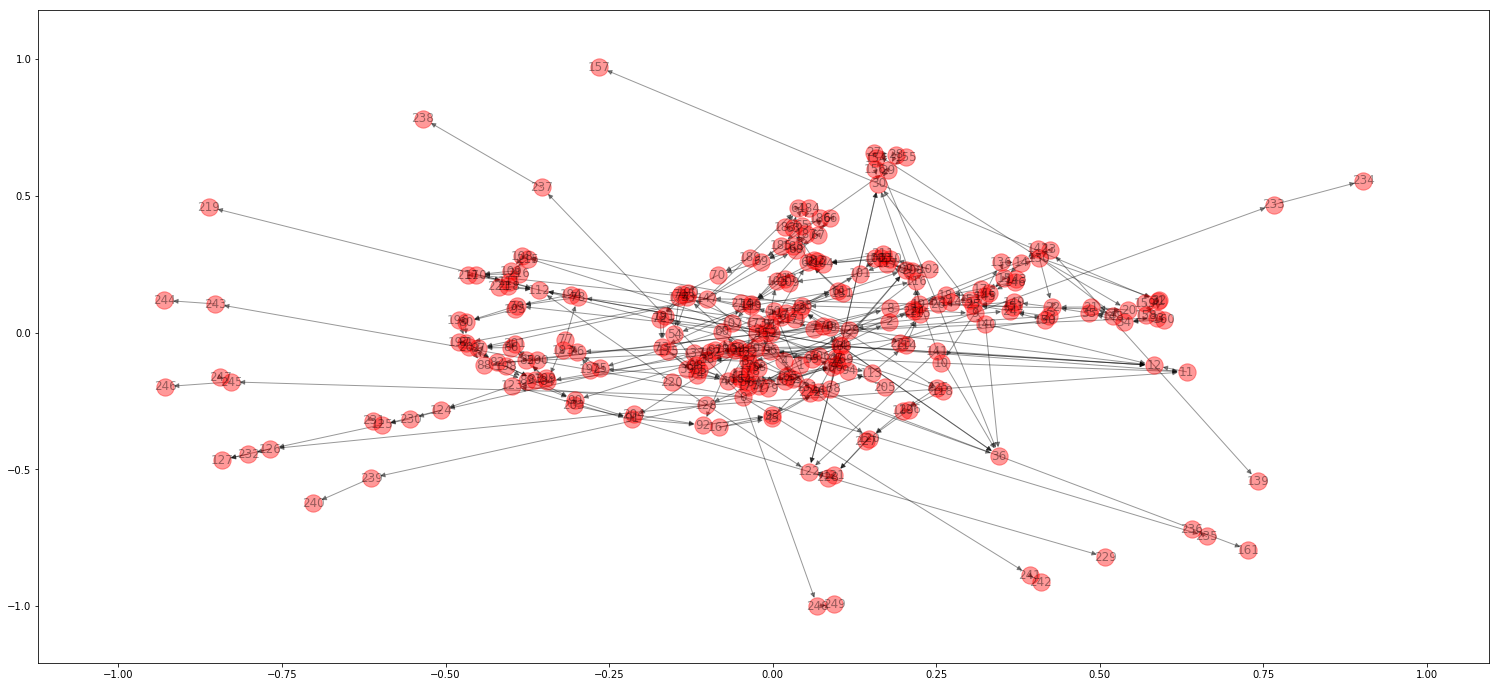

In [10]:
plt.figure(figsize=(26,12))
nx.draw_networkx(nx_graph, alpha=0.4)
plt.show()

# requires graphviz
#nx.drawing.nx_agraph.to_agraph(nx_graph).draw()

### GraphTuple example

In [11]:
# tuple example
graph_tup = graph_tuple.GraphTuple.CreateFromNetworkX(nx_graph)
print([a for a in dir(graph_tup) if '__' not in a])
print('\n')
print('edge_positions', [x.shape for x in graph_tup.edge_positions])

['CreateFromNetworkX', 'CreateFromProgramGraph', 'FromFile', 'FromGraphTuples', 'SetFeaturesAndLabels', 'ToFile', 'ToGraphTuples', 'ToNetworkx', '_asdict', '_field_defaults', '_field_types', '_fields', '_fields_defaults', '_make', '_replace', 'adjacencies', 'call_edge_count', 'control_edge_count', 'count', 'data_edge_count', 'disjoint_graph_count', 'disjoint_nodes_list', 'edge_count', 'edge_position_max', 'edge_positions', 'graph_x', 'graph_x_dimensionality', 'graph_y', 'graph_y_dimensionality', 'has_graph_x', 'has_graph_y', 'has_node_y', 'index', 'is_disjoint_graph', 'node_count', 'node_x', 'node_x_dimensionality', 'node_y', 'node_y_dimensionality']


edge_positions [(140,), (269,), (9,)]


### Collect Token distribution stats on the example

In [12]:
x = graph_tup.node_x.T.squeeze()


bins = np.bincount(x, minlength=8568)
s = np.sum(bins)
for i, c in enumerate(bins):
    if c:
        print(f"{i}  {c}   {(c*100/s):.3f}")

188  1   0.400
215  1   0.400
216  16   6.400
231  1   0.400
252  8   3.200
257  1   0.400
263  1   0.400
289  9   3.600
295  31   12.400
311  8   3.200
364  6   2.400
394  1   0.400
412  1   0.400
431  6   2.400
598  1   0.400
634  1   0.400
658  8   3.200
1122  3   1.200
3722  1   0.400
6277  6   2.400
8564  32   12.800
8565  106   42.400
8567  1   0.400


# Main: Preprocess Datasets

## Dev: tuple2data - GraphTuple -> Pyg data.Data

In [13]:
# data example
edge_indices = [torch.from_numpy(a).to(dtype=torch.long) for a in graph_tup.adjacencies] # list of <M_i, 2>
edge_types = [i * np.ones_like(edge_indices[i])[:,0] for i in range(len(edge_indices))]
edge_attr = np.hstack(edge_types)
print('edge_attr', edge_attr.shape)

t_attr = torch.from_numpy(edge_attr).to(dtype=torch.long).view(-1,1)
print(t_attr.size())
print('edge_indices', [x.shape for x in edge_indices])
print('edge_types', [x.shape for x in edge_types])

#edge_pos = [torch.from_numpy(a).to(dtype=torch.long) for a in graph_tup.edge_positions]
print('graph_tup.edge_positions', [x.shape for x in graph_tup.edge_positions])
edge_pos = np.hstack(graph_tup.edge_positions)

edge_attr = np.vstack([edge_attr, edge_pos])

edge_attr = torch.from_numpy(edge_attr.T).to(torch.long)
print('edge_attr', edge_attr.size())

# node_x as data.x
x = torch.from_numpy(graph_tup.node_x).to(torch.long) #
y = torch.from_numpy(np.array(42)).to(torch.long).view(1)
print('x', x.size())
print('y', y.size())

edge_attr (418,)
torch.Size([418, 1])
edge_indices [torch.Size([140, 2]), torch.Size([269, 2]), torch.Size([9, 2])]
edge_types [(140,), (269,), (9,)]
graph_tup.edge_positions [(140,), (269,), (9,)]
edge_attr torch.Size([418, 2])
x torch.Size([250, 1])
y torch.Size([1])


In [14]:
def tuple2data(graph_tup, class_label):
    # edges as data.edge_index
    # list of <M_i, 2> tensors  (M_i = num_edges for ith edge type)
    edge_indices = [torch.from_numpy(a).to(dtype=torch.long) for a in graph_tup.adjacencies] # list of <M_i, 2>

    edge_index = torch.cat(edge_indices, dim=0).t().contiguous() # <2, M>

    # (edge_type, edge_position) as data.edge_attr of shape <M, 2>
    edge_types = [i * np.ones_like(edge_indices[i])[:,0] for i in range(len(edge_indices))]
    edge_types = np.hstack(edge_types)
    edge_pos = np.hstack(graph_tup.edge_positions)
    edge_attr = np.vstack([edge_types, edge_pos]).T
    
    edge_attr = torch.from_numpy(edge_attr).to(dtype=torch.long).contiguous()  # <M, 2>
    
    assert edge_attr.size()[0] == edge_index.size()[1], f'edge_attr={edge_attr.size()} size mismatch with edge_index={edge_index.size()}'
    
    # node_x as data.x
    x = torch.from_numpy(graph_tup.node_x).to(torch.long)  # <N, 1>
    # class label as y
    y = torch.from_numpy(np.array(class_label)).to(torch.long).view(1)  # <1>

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    return data

In [15]:
# tuple2data example
tuple2data(graph_tup, 42)

Data(edge_attr=[418, 2], edge_index=[2, 418], x=[250, 1], y=[1])

## Dev: nx2data (more flexible!)

### By Example

In [16]:
# inspect format
print(list(nx_graph.edges(data=True))[12])
list(nx_graph.nodes(data=True))[2]

(2, 129, {'position': 0, 'flow': 1})


(2,
 {'function': 'main',
  'type': 0,
  'text': '%n = alloca i32, align 4',
  'preprocessed_text': '<%ID> = alloca i32, align 4',
  'x': [289],
  'y': []})

In [17]:
# Try to "update" the nx_graph.node.x:
from deeplearning.ml4pl.graphs.unlabelled.llvm2graph.node_encoder import GraphNodeEncoder

encoder = GraphNodeEncoder()

# this changes the nx_graph in-place!
encoder.EncodeNodes(nx_graph)

In [18]:
# collect edge_index
edge_index = torch.tensor(list(nx_graph.edges())).t().contiguous()
edge_index.size()

torch.Size([2, 418])

In [19]:
# collect edge attr
positions = []
flows = []
for i, (_, _, edge_data) in enumerate(nx_graph.edges(data=True)):
    positions.append(edge_data['position'])
    flows.append(edge_data['flow'])
positions = torch.tensor(positions)
flows = torch.tensor(flows)
edge_attr = torch.cat([flows, positions]).view(2, -1).t().contiguous()
edge_attr.size()


torch.Size([418, 2])

In [20]:
# collect node attributes
print(list(nx_graph.nodes(data=True))[0], '\n')
print(list(nx_graph.nodes(data=True))[27])


types = []
xs = []
for i, node_data in nx_graph.nodes(data=True):
    types.append(node_data['type'])
    xs.append(node_data['x'])
x = torch.cat([torch.tensor(xs), torch.tensor(xs)]).view(2, -1).t().contiguous()
x.size()


(0, {'type': 0, 'text': 'root', 'preprocessed_text': 'root', 'function': None, 'x': [8564], 'y': []}) 

(27, {'function': 'main', 'type': 0, 'text': '%6 = load i32, i32* %b, align 4', 'preprocessed_text': '<%ID> = load i32, i32* <%ID>, align 4', 'x': [295], 'y': []})


torch.Size([250, 2])

### unit test on this example

### coalesce into nx2data function

In [21]:
def nx2data(nx_graph, class_label):
    r"""Converts a :obj:`networkx.Graph` or :obj:`networkx.DiGraph` to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        G (networkx.Graph or networkx.DiGraph): A networkx graph.
    """

    # make sure the nx_graph is encoded properly (since node.x used to be buggy!)
    # encoder = GraphNodeEncoder()
    # encoder.EncodeNodes(nx_graph)

    # collect edge_index
    edge_index = torch.tensor(list(nx_graph.edges())).t().contiguous()

    # collect edge_attr
    positions = []
    flows = []

    for i, (_, _, edge_data) in enumerate(nx_graph.edges(data=True)):
        positions.append(edge_data['position'])
        flows.append(edge_data['flow'])

    positions = torch.tensor(positions)
    flows = torch.tensor(flows)

    edge_attr = torch.cat([flows, positions]).view(2, -1).t().contiguous()
    
    # collect x
    types = []
    xs = []
    
    for i, node_data in nx_graph.nodes(data=True):
        types.append(node_data['type'])
        xs.append(node_data['x'][0])

    xs = torch.tensor(xs)
    types = torch.tensor(types)
    
    x = torch.cat([xs, types]).view(2, -1).t().contiguous()

    y = torch.tensor(int(class_label)).view(1)  # <1>
    
    assert edge_attr.size()[0] == edge_index.size()[1], f'edge_attr={edge_attr.size()} size mismatch with edge_index={edge_index.size()}'
    
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    return data

In [22]:
# testing 
with open('71.ll', 'r') as f:
    ll = f.read()

nx_graph = builder.Build(ll)

with torch_geometric.debug():
    data = nx2data(nx_graph, 42)

graph_tup = graph_tuple.GraphTuple.CreateFromNetworkX(nx_graph)

data

Data(edge_attr=[418, 2], edge_index=[2, 418], x=[250, 2], y=[1])

In [23]:
# unit test comparison on '71.ll'

golden_data = tuple2data(graph_tup, class_label=42)
print(golden_data)

# test edge_index
print(np.all(np.sort(golden_data.edge_index.numpy()) == np.sort(data.edge_index.numpy())))

# test edge_attr (loose test of plausibility)
print(np.all(np.sort(golden_data.edge_attr.numpy()[:,0]) == np.sort(data.edge_attr.numpy()[:,0])))
print(np.all(np.sort(golden_data.edge_attr.numpy()[:,1]) == np.sort(data.edge_attr.numpy()[:,1])))

# test node_x (can only test x and not type with golden!)
golden_x_sorted = np.sort(golden_data.x.numpy()[:,0])
x_sorted = np.sort(data.x.numpy()[:,0])
print(np.all(golden_x_sorted == x_sorted))
if not np.all(golden_x_sorted == x_sorted):
    print('-------')
    mask = golden_x_sorted != x_sorted
    print(f'golden_x_sorted[mask] =  {golden_x_sorted[mask]}')
    print(f'x_sorted[mask] =         {x_sorted[mask]}')

Data(edge_attr=[418, 2], edge_index=[2, 418], x=[250, 1], y=[1])
True
True
True
True


In [24]:
from multiprocessing import Pool
import tqdm
import os

def dump(outfile, data, mkdir=True):
    if mkdir:
        outfile.parent.mkdir(exist_ok=True, parents=True)
    with open(outfile, 'wb') as f:
        pickle.dump(data, f)

def load(file):
    with open(file, 'rb') as f:
        data = pickle.load(f)
    return data

In [25]:
def preprocess_ds_raw_dir(ds_base, dump_nx=True, dump_tuple=True, dump_data=True, pool_size=12):
    """Preprocess all .ll files in folders named by class ids e.g. ds_base/1, ds_base/2, ...
    into pytorch-geometric data.Data instances.
    
    The intermediate nx graphs and graph_tuples can be saved as well.
    """

    out_base = ds_base.parent / (ds_base.name + '_programl')
    out_base.mkdir(parents=True, exist_ok=True)
    problems = open(out_base / 'problems.txt', 'a')
    print(f"=== DATASET {ds_base}: preprocessing will be saved in {out_base}")

    # get all subfolders 1/ 2/ etc
    folders = [x for x in ds_base.glob('*') if x.is_dir()]

    for i, folder in enumerate(folders):
        try:
            int(folder.name)
        except ValueError as e:
            print(f"Folder {i} has to be named with integervalues, but is {folder.name}.")
            raise e
    
    # multiprocessed loop over folders
    pool = Pool(processes=pool_size)
    task_args = [(folder, dump_nx, dump_tuple, dump_data, out_base) for folder in folders]
    
    for probs in tqdm.tqdm(pool.imap_unordered(_process_single_folder, task_args), total=len(task_args)):
        if len(probs) > 15: # don't print empty strings like '\n\n\n'
            print(probs, file=problems)
    
    pool.close()
    pool.join()

    problems.close()
    print(f" * COMPLETED * === DATASET {ds_base}: preprocessing saved to {out_base}")
    
    

In [26]:
def _process_single_folder(args):
    """The new version will skip tuple creation completely."""
    folder, dump_nx, dump_tuple, dump_data, out_base = args
    del dump_tuple
    
    problems = ""
    
    print(f"=== Opening Folder {str(folder)} ===")
    
    label = int(folder.name)
    files = list(folder.glob('*.ll'))
    
    # iterate over all .ll files in folder and confirm and respectively create the .nx.p and .data.p files
    for i, file in enumerate(files):
        outfile_nx = out_base / '_nx' / folder.name / (file.name.rsplit('.', 1)[0] + '.nx.p')
        outfile_data = out_base / folder.name / (file.name.rsplit('.', 1)[0] + '.data.p')

        # find out where to start processing

        # skip entirely?
        if outfile_data.is_file():
            continue

        # start at step 2: nx --> data ?
        if outfile_nx.is_file():
            nx_graph = load(outfile_nx)            
            data = nx2data(nx_graph, class_label=label)
            dump(outfile_data, data)
            
            # TODO: delete this line soon !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            # also write back nx_file because the tokenization has been bug-fixed!
            # dump(outfile_nx, nx_graph)
            continue
        
        # start in the beginning:
        # ~~~ step 1: .ll --> nx ~~~
        if i % 100 == 0:
            print(f"{folder.name} - [{i}/{len(files)}] Processing {str(file)} ...")
        
        with open(file, 'r') as f:
            bytecode = f.read()

        try:
            nx_graph = builder.Build(bytecode) # nx
            if dump_nx:
                dump(outfile_nx, nx_graph)
        except:
            print(f"***** FAILING ON {str(file)} ... renaming file to .ll_ ")
            problems += str(file)
            problems += '\n'
            file.rename(file.with_suffix('.ll_'))
            continue

        # step 2: nx --> data
        data = nx2data(nx_graph, class_label=label)
        dump(outfile_data, data)

    return problems

In [27]:
def _process_single_folder_deprecated(args):
    folder, dump_nx, dump_tuple, dump_data, out_base = args
    problems = ""
    
    print(f"=== Opening Folder {str(folder)} ===")
    
    label = int(folder.name)
    files = list(folder.glob('*.ll'))
    for i, file in enumerate(files):
        outfile_nx = out_base / '_nx' / folder.name / (file.name.rsplit('.', 1)[0] + '.nx.p')
        outfile_tuple = out_base / '_tuples' / folder.name / (file.name.rsplit('.', 1)[0] + '.tuple.p')
        outfile_data = out_base / folder.name / (file.name.rsplit('.', 1)[0] + '.data.p')

        # find out where to start processing

        # skip entirely?
        if outfile_data.is_file():
            continue

        # start at step 3: tuple -> data?
        if outfile_tuple.is_file():
            graph_tup = load(outfile_tuple)
            
            # ~~~ step 3: tuple --> data ~~~
            data = tuple2data(graph_tup, class_label=label)
            dump(outfile_data, data)
            continue

        # start at step 2: nx --> tuple ?
        if outfile_nx.is_file():
            nx_graph = load(outfile)
            
            # ~~~ step 2: nx --> tuple ~~~
            graph_tup = graph_tuple.GraphTuple.CreateFromNetworkX(nx_graph)
            if dump_tuple:
                dump(outfile_tuple, graph_tup)
            
            # step 3: tuple --> data            
            data = tuple2data(graph_tup, class_label=label)
            dump(outfile_data, data)
            continue
        
        # start in the beginning:
        # ~~~ step 1: .ll --> nx ~~~
        if i % 100 == 0:
            print(f"{folder.name} - [{i}/{len(files)}] Processing {str(file)} ...")
        
        with open(file, 'r') as f:
            bytecode = f.read()

        try:
            nx_graph = builder.Build(bytecode) # nx
            if dump_nx:
                dump(outfile, nx_graph)
        except:
            print(f"***** FAILING ON {str(file)} ... renaming file to .ll_ ")
            problems += str(file)
            problems += '\n'
            file.rename(file.with_suffix('.ll_'))
            continue

        # step 2: nx --> tuple
        graph_tup = graph_tuple.GraphTuple.CreateFromNetworkX(nx_graph)
        if dump_tuple:
            dump(outfile_tuple, graph_tup)

        # step 3: tuple --> data            
        data = tuple2data(graph_tup, class_label=label)
        dump(outfile_data, data)

    return problems

In [10]:
# download dataset if needed
import wget
import zipfile

def download_and_unzip(url, dataset_name, data_folder):
    """
    Download and unzip data set folder from url
    :param url: from which to download
    :param dataset_name: name of data set (for printing)
    :param data_folder: folder in which to put the downloaded data
    """
    print('Downloading', dataset_name, 'data set...')
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
    data_zip = wget.download(url, out=data_folder)
    print('\tunzipping...')
    zip_ = zipfile.ZipFile(data_zip, 'r')
    assert os.path.isdir(data_folder), data_folder
    zip_.extractall(data_folder)
    zip_.close()
    print('\tdone')

def download_classifyapp(dataset_path, dataset_name):
    # get Path object
    if type(dataset_path) == str:
        dataset_path = Path(dataset_path)
    dataset_path = dataset_path / dataset_name
        
    # Acquire data
    if not dataset_path.exists():
        dataset_path.mkdir(parents=True)
        download_and_unzip('https://polybox.ethz.ch/index.php/s/JOBjrfmAjOeWCyl/download',
                                      dataset_name, str(dataset_path.absolute()))
    else:
        print(f'skipped downloading to {str(dataset_path.absolute())}')

## *needs action:*

In [11]:
!pwd

/home/zacharias/ProGraML/deeplearning/ml4pl/poj104


In [13]:
# Set where to store the dataset and download automagically
ds_basepath = Path('/mnt/data/llvm/master_thesis_datasets')

# uncomment this line to save data "in place"
#ds_basepath = Path(repo_root) / 'deeplearning/ml4pl/poj104'

logs_basepath = ds_basepath / 'logs' / 'new_classifyapp_logs'

ds_basepath.mkdir(parents=True, exist_ok=True)
logs_basepath.mkdir(parents=True, exist_ok=True)

download_classifyapp(ds_basepath)

	unzipping...
	done


In [33]:
# link those places into poj104 folder

data_source = str((ds_basepath / 'new_classifyapp_data').absolute())
print(data_source)
data_target = repo_root + '/deeplearning/ml4pl/poj104/'
print(data_target)

logs_source = str(logs_basepath.absolute())
print(logs_source)
logs_target = repo_root + '/deeplearning/ml4pl/poj104/'
print(logs_target)

/mnt/data/llvm/master_thesis_datasets/classifyapp_data
/home/zacharias/ProGraML/deeplearning/ml4pl/poj104/
/mnt/data/llvm/master_thesis_datasets/classifyapp_logs
/home/zacharias/ProGraML/deeplearning/ml4pl/poj104/


In [34]:
! ln -s {data_source} {data_target}
! ln -s {logs_source} {logs_target}
! ls -lah {str(repo_root + '/deeplearning/ml4pl/poj104')} | grep classifyapp

ln: failed to create symbolic link '/home/zacharias/ProGraML/deeplearning/ml4pl/poj104/classifyapp_data': File exists
ln: failed to create symbolic link '/home/zacharias/ProGraML/deeplearning/ml4pl/poj104/classifyapp_logs': File exists
lrwxrwxrwx  1 zacharias zacharias   54 Jan  9 17:06 classifyapp_data -> /mnt/data/llvm/master_thesis_datasets/classifyapp_data
lrwxrwxrwx  1 zacharias zacharias   54 Jan  9 17:06 classifyapp_logs -> /mnt/data/llvm/master_thesis_datasets/classifyapp_logs


### Process validation set

In [36]:
# start processing the smaller validation dataset
dataset_path = ds_basepath / Path('classifyapp_data/ir_val')
print(dataset_path.name)

preprocess_ds_raw_dir(dataset_path, pool_size=16)

ir_val
=== DATASET /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val: preprocessing will be saved in /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val_programl


  0%|          | 0/104 [00:00<?, ?it/s]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/26 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/18 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/9 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/89 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/45 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/54 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/99 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/32 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/22 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/11 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/77 ===
=== Opening Folder /mnt/data/llvm

  1%|          | 1/104 [00:48<1:22:55, 48.31s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/46 ===
46 - [0/75] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/46/2397.ll ...


  2%|▏         | 2/104 [00:48<57:47, 33.99s/it]  

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/48 ===
48 - [0/86] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/48/994.ll ...


  3%|▎         | 3/104 [00:49<40:35, 24.12s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/5 ===
5 - [0/110] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/5/678.ll ...


  4%|▍         | 4/104 [00:51<28:59, 17.40s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/65 ===
65 - [0/85] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/65/916.ll ...


  5%|▍         | 5/104 [00:52<20:15, 12.27s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/13 ===
13 - [0/94] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/13/1715.ll ...


  6%|▌         | 6/104 [00:56<16:09,  9.90s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/93 ===
93 - [0/93] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/93/2067.ll ...
77 - [100/103] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/77/228.ll ...


  7%|▋         | 7/104 [01:12<19:04, 11.79s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/51 ===
51 - [0/99] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/51/17.ll ...


  8%|▊         | 8/104 [01:13<13:30,  8.44s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/86 ===
86 - [0/85] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/86/678.ll ...


  9%|▊         | 9/104 [01:13<09:27,  5.97s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/2 ===
2 - [0/83] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/2/256.ll ...


 10%|▉         | 10/104 [01:15<07:31,  4.80s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/95 ===
95 - [0/95] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/95/801.ll ...


 11%|█         | 11/104 [01:16<05:39,  3.65s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/23 ===
23 - [0/79] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/23/17.ll ...
14 - [100/107] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/14/253.ll ...


 12%|█▏        | 12/104 [01:21<06:09,  4.02s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/104 ===
104 - [0/87] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/104/435.ll ...


 12%|█▎        | 13/104 [01:22<04:41,  3.09s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/63 ===
63 - [0/85] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/63/2087.ll ...


 13%|█▎        | 14/104 [01:24<04:06,  2.74s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/49 ===
49 - [0/104] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/49/475.ll ...


 14%|█▍        | 15/104 [01:53<15:46, 10.64s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/71 ===
71 - [0/107] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/71/1542.ll ...


 15%|█▌        | 16/104 [02:04<15:42, 10.71s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/76 ===
76 - [0/97] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/76/5.ll ...


 16%|█▋        | 17/104 [02:07<12:27,  8.59s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/79 ===
79 - [0/77] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/79/3884.ll ...


 17%|█▋        | 18/104 [02:10<09:39,  6.74s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/70 ===
70 - [0/81] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/70/200.ll ...


 18%|█▊        | 19/104 [02:12<07:34,  5.35s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/19 ===
19 - [0/93] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/19/678.ll ...
Removed 1 block without predecessors from `main`, 27 blocks remaining
59 - [100/106] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/59/41.ll ...


 19%|█▉        | 20/104 [02:16<06:57,  4.96s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/80 ===
80 - [0/86] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/80/475.ll ...


 20%|██        | 21/104 [02:18<05:45,  4.16s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/96 ===
96 - [0/81] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/96/319.ll ...
5 - [100/110] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/5/465.ll ...


 21%|██        | 22/104 [02:21<05:15,  3.85s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/78 ===
78 - [0/101] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/78/1435.ll ...


 22%|██▏       | 23/104 [02:22<03:59,  2.96s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/91 ===
91 - [0/93] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/91/1061.ll ...


 23%|██▎       | 24/104 [02:28<04:59,  3.75s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/29 ===
18 - [100/101] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/18/663.ll ...
29 - [0/87] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/29/1308.ll ...


 24%|██▍       | 25/104 [02:29<03:55,  2.98s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/100 ===
100 - [0/108] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/100/2397.ll ...


 25%|██▌       | 26/104 [02:32<03:50,  2.95s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/66 ===
66 - [0/98] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/66/1553.ll ...
Removed 1 block without predecessors from `main`, 99 blocks remaining


 26%|██▌       | 27/104 [02:34<03:21,  2.61s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/10 ===
10 - [0/76] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/10/2087.ll ...
49 - [100/104] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/49/337.ll ...


 27%|██▋       | 28/104 [02:44<06:16,  4.95s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/56 ===
56 - [0/100] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/56/1988.ll ...


 28%|██▊       | 29/104 [02:51<07:03,  5.65s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/90 ===
90 - [0/75] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/90/1396.ll ...
Removed 1 block without predecessors from `_Z7maintooii`, 13 blocks remaining


 29%|██▉       | 30/104 [03:01<08:16,  6.71s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/31 ===
31 - [0/63] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/31/1988.ll ...


 30%|██▉       | 31/104 [03:04<07:07,  5.86s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/97 ===
97 - [0/83] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/97/788.ll ...
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/37 ===
37 - [0/77] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/37/1204.ll ...


 32%|███▏      | 33/104 [03:06<05:05,  4.31s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/82 ===
82 - [0/95] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/82/17.ll ...


 33%|███▎      | 34/104 [03:17<07:17,  6.25s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/85 ===
85 - [0/99] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/85/1073.ll ...


 34%|███▎      | 35/104 [03:27<08:29,  7.39s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/74 ===
74 - [0/89] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/74/1308.ll ...


 35%|███▍      | 36/104 [03:30<07:10,  6.33s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/34 ===
34 - [0/91] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/34/76.ll ...
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/24 ===
24 - [0/91] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/24/2470.ll ...


 37%|███▋      | 38/104 [03:32<05:04,  4.62s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/43 ===
43 - [0/75] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/43/1073.ll ...
71 - [100/107] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/71/1426.ll ...


 38%|███▊      | 39/104 [03:38<05:33,  5.13s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/39 ===
39 - [0/92] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/39/1988.ll ...


 38%|███▊      | 40/104 [03:38<03:54,  3.67s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/6 ===
6 - [0/92] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/6/2470.ll ...


 39%|███▉      | 41/104 [03:39<02:45,  2.63s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/38 ===
38 - [0/85] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/38/867.ll ...
Removed 1 block without predecessors from `_Z7converti`, 4 blocks remaining


 40%|████      | 42/104 [03:44<03:35,  3.48s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/67 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/40 ===
40 - [0/46] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/40/1204.ll ...
67 - [0/86] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/67/1988.ll ...
Removed 1 block without predecessors from `_Z8take_ansv`, 41 blocks remaining


 42%|████▏     | 44/104 [04:05<05:32,  5.54s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/72 ===
72 - [0/95] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/72/678.ll ...


 43%|████▎     | 45/104 [04:07<04:25,  4.51s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/55 ===
55 - [0/83] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/55/794.ll ...
100 - [100/108] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/100/21.ll ...


 44%|████▍     | 46/104 [04:12<04:40,  4.84s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/7 ===
7 - [0/98] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/7/678.ll ...


 45%|████▌     | 47/104 [04:14<03:37,  3.82s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/87 ===
87 - [0/90] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/87/1073.ll ...
78 - [100/101] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/78/1384.ll ...


 46%|████▌     | 48/104 [04:18<03:40,  3.94s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/8 ===
8 - [0/75] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/8/1308.ll ...


 47%|████▋     | 49/104 [04:19<02:52,  3.14s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/16 ===
16 - [0/87] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/16/5.ll ...


 48%|████▊     | 50/104 [04:20<02:05,  2.33s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/61 ===
61 - [0/79] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/61/1285.ll ...


 49%|████▉     | 51/104 [04:24<02:30,  2.84s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/58 ===
58 - [0/86] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/58/801.ll ...


 50%|█████     | 52/104 [04:24<01:48,  2.09s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/53 ===
53 - [0/90] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/53/1466.ll ...


 51%|█████     | 53/104 [04:31<02:53,  3.40s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/62 ===
62 - [0/86] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/62/2445.ll ...


 52%|█████▏    | 54/104 [04:36<03:16,  3.93s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/60 ===
60 - [0/79] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/60/446.ll ...
Removed 1 block without predecessors from `main`, 28 blocks remaining


 53%|█████▎    | 55/104 [04:46<04:38,  5.69s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/30 ===
30 - [0/103] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/30/358.ll ...


 54%|█████▍    | 56/104 [04:46<03:23,  4.23s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/20 ===
20 - [0/84] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/20/1308.ll ...


 55%|█████▍    | 57/104 [04:53<03:50,  4.90s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/68 ===
68 - [0/96] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/68/668.ll ...


 56%|█████▌    | 58/104 [04:54<02:56,  3.83s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/35 ===
35 - [0/89] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/35/1308.ll ...


 57%|█████▋    | 59/104 [05:01<03:37,  4.83s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/1 ===
1 - [0/89] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/1/1988.ll ...


 58%|█████▊    | 60/104 [05:03<02:54,  3.97s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/36 ===
36 - [0/92] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/36/1684.ll ...


 59%|█████▊    | 61/104 [05:03<02:02,  2.85s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/81 ===
81 - [0/111] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/81/658.ll ...
Removed 1 block without predecessors from `_Z2sciPiiS_`, 9 blocks remaining
Removed 1 block without predecessors from `_Z2pxiPi`, 11 blocks remaining
Removed 1 block without predecessors from `_Z6readiniPi`, 5 blocks remaining


 60%|█████▉    | 62/104 [05:07<02:02,  2.91s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/94 ===
94 - [0/64] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/94/658.ll ...
Removed 2 blocks without predecessors from `main`, 35 blocks remaining
Removed 1 block without predecessors from `_Z2dyv`, 5 blocks remaining
Removed 1 block without predecessors from `_Z2pxv`, 21 blocks remaining
Removed 1 block without predecessors from `_Z2gbv`, 9 blocks remaining
Removed 1 block without predecessors from `_Z5orderiPi`, 11 blocks remaining
Removed 1 block without predecessors from `_Z6outputiPi`, 7 blocks remaining
Removed 1 block without predecessors from `_Z5inputiPi`, 5 blocks remaining
Removed 1 block without predecessors from `_Z7combinePiS_iiS_`, 9 blocks remaining


 61%|██████    | 63/104 [05:22<04:37,  6.77s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/3 ===
3 - [0/79] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/3/2067.ll ...


 62%|██████▏   | 64/104 [05:25<03:36,  5.40s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/44 ===
44 - [0/83] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/44/1308.ll ...


 62%|██████▎   | 65/104 [05:26<02:48,  4.33s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/98 ===
98 - [0/84] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/98/981.ll ...
Removed 1 block without predecessors from `main`, 22 blocks remaining


 63%|██████▎   | 66/104 [05:32<02:56,  4.65s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/64 ===
64 - [0/80] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/64/2764.ll ...
Removed 1 block without predecessors from `main`, 28 blocks remaining
Removed 1 block without predecessors from `main`, 35 blocks remaining


 64%|██████▍   | 67/104 [05:36<02:45,  4.47s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/42 ===
42 - [0/114] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/42/1466.ll ...
30 - [100/103] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/30/458.ll ...


 65%|██████▌   | 68/104 [05:41<02:49,  4.72s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/17 ===
17 - [0/85] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/17/658.ll ...


 66%|██████▋   | 69/104 [05:42<02:01,  3.48s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/69 ===
69 - [0/80] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/69/801.ll ...


 67%|██████▋   | 70/104 [05:46<02:07,  3.75s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/15 ===
15 - [0/96] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/15/658.ll ...


 68%|██████▊   | 71/104 [05:47<01:37,  2.97s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/41 ===
41 - [0/91] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/41/994.ll ...
Removed 1 block without predecessors from `main`, 14 blocks remaining
***** FAILING ON /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/17/657.ll ... renaming file to .ll_ 


 69%|██████▉   | 72/104 [05:56<02:28,  4.65s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/73 ===
73 - [0/89] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/73/801.ll ...


 70%|███████   | 73/104 [05:59<02:10,  4.21s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/27 ===
27 - [0/58] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/27/1396.ll ...


 71%|███████   | 74/104 [06:03<02:00,  4.01s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/52 ===
52 - [0/90] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/52/319.ll ...


 72%|███████▏  | 75/104 [06:09<02:16,  4.71s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/102 ===
102 - [0/64] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/102/788.ll ...


 73%|███████▎  | 76/104 [06:13<02:11,  4.69s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/57 ===
57 - [0/93] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/57/1988.ll ...


 74%|███████▍  | 77/104 [06:15<01:40,  3.73s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/25 ===
25 - [0/74] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/25/1073.ll ...


 75%|███████▌  | 78/104 [06:16<01:14,  2.87s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/103 ===
103 - [0/74] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/103/788.ll ...


 76%|███████▌  | 79/104 [06:24<01:54,  4.59s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/50 ===
50 - [0/86] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/50/678.ll ...
Removed 1 block without predecessors from `main`, 33 blocks remaining
***** FAILING ON /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/17/885.ll ... renaming file to .ll_ 
81 - [100/111] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/81/114.ll ...


 77%|███████▋  | 80/104 [06:34<02:27,  6.15s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/21 ===
21 - [0/91] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/21/379.ll ...


 78%|███████▊  | 81/104 [06:39<02:12,  5.76s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/101 ===
101 - [0/95] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/101/658.ll ...
Removed 1 block without predecessors from `main`, 20 blocks remaining
42 - [100/114] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/42/1736.ll ...


 79%|███████▉  | 82/104 [06:44<01:58,  5.38s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/33 ===
33 - [0/100] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/33/1871.ll ...
Removed 1 block without predecessors from `main`, 26 blocks remaining
***** FAILING ON /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/17/659.ll ... renaming file to .ll_ 


 80%|███████▉  | 83/104 [06:53<02:20,  6.67s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/92 ===
92 - [0/55] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/92/307.ll ...


 81%|████████  | 84/104 [06:59<02:06,  6.30s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/84 ===
84 - [0/107] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/84/2397.ll ...


 82%|████████▏ | 85/104 [06:59<01:27,  4.59s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/83 ===
83 - [0/108] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/83/4074.ll ...


 83%|████████▎ | 86/104 [07:00<01:01,  3.42s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/47 ===
47 - [0/93] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/47/13.ll ...


 84%|████████▎ | 87/104 [07:04<00:59,  3.50s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/88 ===
88 - [0/91] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/88/475.ll ...


 85%|████████▍ | 88/104 [07:07<00:57,  3.59s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/12 ===
12 - [0/82] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/12/1308.ll ...


 92%|█████████▏| 96/104 [07:40<00:41,  5.13s/it]

84 - [100/107] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/84/3230.ll ...


 99%|█████████▉| 103/104 [07:49<00:01,  1.49s/it]

83 - [100/108] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val/83/572.ll ...


100%|██████████| 104/104 [08:11<00:00,  7.48s/it]

 * COMPLETED * === DATASET /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val: preprocessing saved to /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_val_programl


### Process test set

In [37]:
# test dataset
dataset_path = ds_basepath / Path('classifyapp_data/ir_test')
print(dataset_path.name)

preprocess_ds_raw_dir(dataset_path, pool_size=16)

ir_test
=== DATASET /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test: preprocessing will be saved in /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test_programl
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/18 ===
32 - [0/85] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/32/2087.ll ...
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/9 ===


  0%|          | 0/104 [00:00<?, ?it/s]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/45 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/26 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/22 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/54 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/32 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/89 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/77 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/11 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/99 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/75 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/59 ===
=== Opening Folder /m

  1%|          | 1/104 [00:40<1:10:09, 40.87s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/46 ===
46 - [0/124] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/46/2087.ll ...
Removed 1 block without predecessors from `main`, 38 blocks remaining


  2%|▏         | 2/104 [00:50<53:45, 31.62s/it]  

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/48 ===
48 - [0/89] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/48/658.ll ...
54 - [100/104] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/54/1124.ll ...


  3%|▎         | 3/104 [00:53<38:35, 22.92s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/5 ===
5 - [0/85] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/5/137.ll ...
45 - [100/105] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/45/2498.ll ...
Removed 1 block without predecessors from `main`, 20 blocks remaining
Removed 1 block without predecessors from `_Z4linePcPi`, 19 blocks remaining


  4%|▍         | 4/104 [00:59<29:52, 17.92s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/65 ===
65 - [0/92] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/65/801.ll ...
28 - [100/109] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/28/552.ll ...


  5%|▍         | 5/104 [01:03<22:26, 13.60s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/13 ===
13 - [0/96] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/13/1308.ll ...
99 - [100/102] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/99/1181.ll ...


  6%|▌         | 6/104 [01:05<16:45, 10.26s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/93 ===
93 - [0/98] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/93/17.ll ...


  7%|▋         | 7/104 [01:06<11:48,  7.31s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/51 ===
51 - [0/72] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/51/1073.ll ...


  8%|▊         | 8/104 [01:07<08:58,  5.61s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/86 ===
86 - [0/100] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/86/1599.ll ...


  9%|▊         | 9/104 [01:09<06:51,  4.33s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/2 ===
2 - [0/75] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/2/17.ll ...


 10%|▉         | 10/104 [01:17<08:36,  5.50s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/95 ===
95 - [0/101] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/95/788.ll ...


 11%|█         | 11/104 [01:17<06:04,  3.91s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/23 ===
23 - [0/98] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/23/256.ll ...


 12%|█▏        | 12/104 [01:20<05:24,  3.52s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/104 ===
104 - [0/92] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/104/678.ll ...


 12%|█▎        | 13/104 [01:22<04:55,  3.24s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/63 ===
63 - [0/72] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/63/1871.ll ...
11 - [100/103] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/11/149.ll ...


 13%|█▎        | 14/104 [01:27<05:20,  3.56s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/49 ===
49 - [0/97] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/49/740.ll ...


 14%|█▍        | 15/104 [01:50<14:04,  9.49s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/71 ===
71 - [0/95] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/71/1988.ll ...
Removed 1 block without predecessors from `_Z7osubstrPcii`, 4 blocks remaining


 15%|█▌        | 16/104 [02:07<17:14, 11.76s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/76 ===
76 - [0/88] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/76/17.ll ...
Removed 1 block without predecessors from `_Z4turnPc`, 22 blocks remaining


 16%|█▋        | 17/104 [02:10<13:24,  9.24s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/79 ===
79 - [0/82] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/79/1466.ll ...


 17%|█▋        | 18/104 [02:14<10:47,  7.53s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/70 ===
70 - [0/84] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/70/548.ll ...


 18%|█▊        | 19/104 [02:17<08:48,  6.22s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/19 ===
19 - [0/103] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/19/658.ll ...


 19%|█▉        | 20/104 [02:18<06:32,  4.68s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/80 ===
80 - [0/104] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/80/801.ll ...


 20%|██        | 21/104 [02:21<05:42,  4.12s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/96 ===
96 - [0/68] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/96/788.ll ...


 21%|██        | 22/104 [02:22<04:14,  3.11s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/78 ===
78 - [0/100] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/78/1861.ll ...


 22%|██▏       | 23/104 [02:22<03:01,  2.24s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/91 ===
91 - [0/84] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/91/17.ll ...


 23%|██▎       | 24/104 [02:26<03:53,  2.92s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/29 ===
29 - [0/105] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/29/17.ll ...


 24%|██▍       | 25/104 [02:28<03:27,  2.62s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/100 ===
100 - [0/97] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/100/81.ll ...


 25%|██▌       | 26/104 [02:31<03:15,  2.51s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/66 ===
66 - [0/101] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/66/1073.ll ...
46 - [100/124] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/46/1840.ll ...
95 - [100/101] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/95/293.ll ...


 26%|██▌       | 27/104 [02:36<04:13,  3.30s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/10 ===
10 - [0/77] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/10/1957.ll ...


 27%|██▋       | 28/104 [02:38<03:52,  3.06s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/56 ===
56 - [0/82] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/56/2445.ll ...


 28%|██▊       | 29/104 [02:41<03:36,  2.89s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/90 ===
90 - [0/71] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/90/1466.ll ...


 29%|██▉       | 30/104 [02:57<08:38,  7.01s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/31 ===
31 - [0/73] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/31/1714.ll ...


 30%|██▉       | 31/104 [03:00<06:54,  5.68s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/97 ===
97 - [0/97] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/97/1715.ll ...


 31%|███       | 32/104 [03:10<08:13,  6.85s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/37 ===
37 - [0/85] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/37/475.ll ...


 32%|███▏      | 33/104 [03:12<06:28,  5.47s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/82 ===
82 - [0/95] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/82/994.ll ...
Removed 1 block without predecessors from `main`, 38 blocks remaining


 33%|███▎      | 34/104 [03:17<06:13,  5.34s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/85 ===
85 - [0/78] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/85/1204.ll ...
Removed 1 block without predecessors from `_Z1fiii`, 4 blocks remaining
29 - [100/105] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/29/979.ll ...


 34%|███▎      | 35/104 [03:24<06:42,  5.83s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/74 ===
74 - [0/96] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/74/658.ll ...


 35%|███▍      | 36/104 [03:24<04:41,  4.14s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/34 ===
34 - [0/104] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/34/17.ll ...


 36%|███▌      | 37/104 [03:26<03:54,  3.50s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/24 ===
24 - [0/93] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/24/1542.ll ...


 37%|███▋      | 38/104 [03:26<02:51,  2.59s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/43 ===
43 - [0/95] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/43/1599.ll ...


 38%|███▊      | 39/104 [03:31<03:25,  3.17s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/39 ===
39 - [0/81] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/39/1715.ll ...


 38%|███▊      | 40/104 [03:33<02:51,  2.69s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/6 ===
6 - [0/101] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/6/2087.ll ...
19 - [100/103] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/19/2872.ll ...
Removed 1 block without predecessors from `_Z8guochengi`, 7 blocks remaining


 39%|███▉      | 41/104 [03:44<05:25,  5.17s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/38 ===
38 - [0/79] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/38/788.ll ...


 40%|████      | 42/104 [03:45<04:05,  3.96s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/67 ===
67 - [0/87] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/67/2445.ll ...


 41%|████▏     | 43/104 [03:48<03:44,  3.68s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/40 ===
40 - [0/41] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/40/2662.ll ...
Removed 1 block without predecessors from `_Z1fddddd`, 4 blocks remaining


 42%|████▏     | 44/104 [04:08<08:32,  8.54s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/72 ===
72 - [0/84] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/72/2445.ll ...


 43%|████▎     | 45/104 [04:08<06:00,  6.11s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/55 ===
55 - [0/81] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/55/678.ll ...


 44%|████▍     | 46/104 [04:17<06:40,  6.90s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/7 ===
7 - [0/84] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/7/1131.ll ...
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/87 ===
87 - [0/107] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/87/678.ll ...


 46%|████▌     | 48/104 [04:18<04:39,  4.99s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/8 ===
8 - [0/92] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/8/1435.ll ...
34 - [100/104] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/34/1228.ll ...
66 - [100/101] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/66/454.ll ...


 47%|████▋     | 49/104 [04:22<04:25,  4.83s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/16 ===
16 - [0/94] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/16/740.ll ...
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/61 ===
61 - [0/88] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/61/17.ll ...
80 - [100/104] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/80/224.ll ...
Removed 1 block without predecessors from `_Z6shuchuv`, 5 blocks remaining
Removed 1 block without predecessors from `_Z5shuruv`, 9 blocks remaining
Removed 1 block without predecessors from `_Z3paiv`, 21 blocks remaining
Removed 1 block without predecessors from `_Z3jiev`, 9 blocks remaining


 49%|████▉     | 51/104 [04:27<03:37,  4.11s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/58 ===
58 - [0/108] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/58/658.ll ...


 50%|█████     | 52/104 [04:27<02:32,  2.94s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/53 ===
53 - [0/92] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/53/658.ll ...
Removed 1 block without predecessors from `main`, 29 blocks remaining


 51%|█████     | 53/104 [04:33<03:06,  3.65s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/62 ===
62 - [0/98] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/62/2087.ll ...
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/60 ===
60 - [0/89] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/60/1599.ll ...
Removed 1 block without predecessors from `main`, 21 blocks remaining


 53%|█████▎    | 55/104 [04:37<02:37,  3.22s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/30 ===
30 - [0/87] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/30/2287.ll ...


 54%|█████▍    | 56/104 [04:41<02:43,  3.40s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/20 ===
20 - [0/101] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/20/548.ll ...


 55%|█████▍    | 57/104 [04:47<03:12,  4.09s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/68 ===
68 - [0/85] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/68/567.ll ...
Removed 1 block without predecessors from `main`, 22 blocks remaining
Removed 1 block without predecessors from `main`, 26 blocks remaining
Removed 1 block without predecessors from `_Z1fPii`, 11 blocks remaining
6 - [100/101] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/6/4140.ll ...


 56%|█████▌    | 58/104 [04:56<04:22,  5.71s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/35 ===
35 - [0/80] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/35/801.ll ...


 57%|█████▋    | 59/104 [04:57<03:15,  4.34s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/1 ===
1 - [0/88] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/1/801.ll ...


 58%|█████▊    | 60/104 [05:10<04:58,  6.78s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/36 ===
36 - [0/111] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/36/788.ll ...
87 - [100/107] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/87/277.ll ...


 59%|█████▊    | 61/104 [05:12<03:59,  5.57s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/81 ===
81 - [0/96] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/81/1725.ll ...


 60%|█████▉    | 62/104 [05:15<03:18,  4.73s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/94 ===
94 - [0/68] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/94/1435.ll ...


 61%|██████    | 63/104 [05:24<04:00,  5.86s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/3 ===
3 - [0/87] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/3/1957.ll ...


 62%|██████▏   | 64/104 [05:27<03:24,  5.12s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/44 ===
44 - [0/89] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/44/379.ll ...


 62%|██████▎   | 65/104 [05:28<02:34,  3.95s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/98 ===
98 - [0/84] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/98/678.ll ...


 63%|██████▎   | 66/104 [05:29<01:53,  3.00s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/64 ===
64 - [0/67] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/64/1553.ll ...
Removed 1 block without predecessors from `_Z1fii`, 40 blocks remaining


 64%|██████▍   | 67/104 [05:35<02:20,  3.78s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/42 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/17 ===
42 - [0/82] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/42/994.ll ...
17 - [0/77] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/17/584.ll ...
Removed 1 block without predecessors from `main`, 21 blocks remaining
Removed 1 block without predecessors from `main`, 41 blocks remaining
***** FAILING ON /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/17/650.ll ... renaming file to .ll_ 
Removed 1 block without predecessors from `main`, 28 blocks remaining
Removed 1 block without predecessors from `_Z3fffiiii`, 11 blocks remaining
Removed 1 block without predecessors from `_Z5countii`, 9 blocks remaining
Removed 1 block without predecessors from `_Z7reversei`, 20 blocks remaining


 66%|██████▋   | 69/104 [05:52<03:02,  5.23s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/69 ===
69 - [0/70] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/69/722.ll ...


 67%|██████▋   | 70/104 [05:54<02:24,  4.25s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/15 ===
15 - [0/92] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/15/1308.ll ...
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/41 ===
41 - [0/91] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/41/17.ll ...


 69%|██████▉   | 72/104 [05:58<01:52,  3.53s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/73 ===
73 - [0/86] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/73/788.ll ...
20 - [100/101] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/20/293.ll ...


 70%|███████   | 73/104 [06:01<01:44,  3.38s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/27 ===
27 - [0/66] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/27/658.ll ...
58 - [100/108] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/58/10.ll ...


 71%|███████   | 74/104 [06:06<02:03,  4.11s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/52 ===
52 - [0/92] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/52/788.ll ...


 72%|███████▏  | 75/104 [06:09<01:50,  3.80s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/102 ===
102 - [0/68] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/102/475.ll ...
Removed 1 block without predecessors from `_Z5fanxui`, 3 blocks remaining
Removed 1 block without predecessors from `_Z3paiPiii`, 12 blocks remaining


 73%|███████▎  | 76/104 [06:14<01:51,  3.99s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/57 ===
57 - [0/99] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/57/2397.ll ...


 74%|███████▍  | 77/104 [06:18<01:52,  4.17s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/25 ===
25 - [0/85] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/25/17.ll ...
36 - [100/111] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/36/515.ll ...


 75%|███████▌  | 78/104 [06:27<02:23,  5.52s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/103 ===
103 - [0/72] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/103/801.ll ...


 76%|███████▌  | 79/104 [06:31<02:08,  5.13s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/50 ===
50 - [0/95] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/50/1599.ll ...


 77%|███████▋  | 80/104 [06:36<02:00,  5.01s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/21 ===
21 - [0/79] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/21/2087.ll ...
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/101 ===
101 - [0/100] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/101/788.ll ...


 79%|███████▉  | 82/104 [06:37<01:20,  3.67s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/33 ===
33 - [0/99] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/33/3314.ll ...
Removed 1 block without predecessors from `main`, 33 blocks remaining


 80%|███████▉  | 83/104 [06:41<01:20,  3.82s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/92 ===
92 - [0/57] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/92/801.ll ...
Removed 2 blocks without predecessors from `main`, 28 blocks remaining


 81%|████████  | 84/104 [06:49<01:40,  5.01s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/84 ===
84 - [0/89] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/84/4001.ll ...


 82%|████████▏ | 85/104 [06:51<01:15,  3.98s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/83 ===
83 - [0/80] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/83/1073.ll ...


 83%|████████▎ | 86/104 [07:02<01:51,  6.18s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/47 ===
47 - [0/92] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/47/4202.ll ...


 84%|████████▎ | 87/104 [07:03<01:16,  4.50s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/88 ===
88 - [0/89] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/88/788.ll ...
Removed 1 block without predecessors from `_Z1Fiii`, 9 blocks remaining


 85%|████████▍ | 88/104 [07:06<01:05,  4.08s/it]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/12 ===
12 - [0/106] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/12/678.ll ...


 89%|████████▉ | 93/104 [07:23<00:29,  2.71s/it]

Removed 1 block without predecessors from `_Z4sortPii`, 11 blocks remaining
Removed 1 block without predecessors from `_Z8functioni`, 1 blocks remaining
Removed 1 block without predecessors from `main`, 21 blocks remaining
***** FAILING ON /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/12/1373.ll ... renaming file to .ll_ 


 90%|█████████ | 94/104 [07:36<00:56,  5.65s/it]

Removed 1 block without predecessors from `main`, 9 blocks remaining
***** FAILING ON /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/88/588.ll ... renaming file to .ll_ 


 94%|█████████▍| 98/104 [07:39<00:11,  1.99s/it]

Removed 1 block without predecessors from `main`, 20 blocks remaining


 98%|█████████▊| 102/104 [07:50<00:04,  2.29s/it]

12 - [100/106] Processing /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test/12/645.ll ...


100%|██████████| 104/104 [07:55<00:00,  2.47s/it]

 * COMPLETED * === DATASET /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test: preprocessing saved to /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_test_programl


### Process train set

In [39]:
# train dataset
dataset_path = ds_basepath / Path('classifyapp_data/ir_train')
print(dataset_path.name)

preprocess_ds_raw_dir(dataset_path, pool_size=16)

ir_train
=== DATASET /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train: preprocessing will be saved in /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train_programl


  0%|          | 0/104 [00:00<?, ?it/s]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/89 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/9 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/18 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/45 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/26 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/54 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/32 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/22 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/99 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/77 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/11 ===
=== Opening

  1%|          | 1/104 [00:00<00:46,  2.22it/s]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/46 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/48 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/65 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/93 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/51 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/13 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/5 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/86 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/2 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/95 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/23 ===
=== Opening 

 16%|█▋        | 17/104 [00:00<00:27,  3.15it/s]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/79 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/70 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/19 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/80 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/96 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/78 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/91 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/29 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/100 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/66 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/10 ===
=== Openi

 34%|███▎      | 35/104 [00:00<00:15,  4.47it/s]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/74 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/24 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/34 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/43 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/39 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/6 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/38 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/67 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/40 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/72 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/55 ===
=== Opening

 47%|████▋     | 49/104 [00:00<00:08,  6.29it/s]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/16 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/61 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/58 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/53 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/62 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/60 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/30 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/20 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/68 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/35 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/36 ===
=== Openin

 62%|██████▏   | 64/104 [00:00<00:04,  8.83it/s]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/44 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/98 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/64 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/42 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/17 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/69 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/15 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/41 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/73 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/52 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/102 ===
=== Openi

 79%|███████▉  | 82/104 [00:00<00:01, 12.33it/s]

=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/33 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/92 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/84 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/83 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/47 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/88 ===
=== Opening Folder /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train/12 ===


100%|██████████| 104/104 [00:01<00:00, 94.57it/s]


 * COMPLETED * === DATASET /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train: preprocessing saved to /mnt/data/llvm/master_thesis_datasets/classifyapp_data/ir_train_programl


# Development of Pytorch-Geometric Dataset

In [ ]:
# naive dataloader that works on a list of data.Data instances in memory.

def get_dataloader(self, ds_base, config):
    ds_base = Path(ds_base) if type(ds_base) is str else ds_base
    datalist = []
    out_base = ds_base.parent / (ds_base.name + "_programl")
    print(f"=== DATASET {ds_base}: getting dataloader")

    folders = [x for x in out_base.glob("*") if x.is_dir() and x.name not in ['_nx', '_tuples']]
    for folder in tqdm.tqdm(folders):
        # skip classes that are larger than what config says to enable debugging with less data
        if int(folder.name) > config.num_classes:
            continue
        # print(f"=== Opening Folder {str(folder)} ===")
        for k, file in enumerate(folder.glob("*.data.p")):
            # print(f"{k} - Processing {str(file)} ...")
            with open(file, "rb") as f:
                data = pickle.load(f)
            datalist.append(data)
    print(f" * COMPLETED * === DATASET {ds_base}: returning dataloader")
    return DataLoader(datalist, batch_size=config.batch_size, shuffle=True)


# Finished Dataset

In [ ]:
from deeplearning.ml4pl.poj104.dataset import POJ104Dataset

In [ ]:
#raw_data_path = '/mnt/data/llvm/master_thesis_datasets/classifyapp_data/'
raw_data_path = repo_root + '/deeplearning/ml4pl/poj104/classifyapp_data'
print(raw_data_path)

In [ ]:
POJ104Dataset()

# TBD: upcoming work section